# Introduction
This notebook is used to explore the dataset we are going to use for the project.

In [189]:
# imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


### Load
We take the season.csv datasets from 2019, 2020, 2021 and 2022 and merge them into one dataset.

In [190]:
base_path = 'data'
file_name = 'season.csv'
type_dict ={
    'LapStartTime': np.float32,
    'LapNumber': np.uint8,
    'LapTime': np.float32,
    'DriverNumber': "category",
    'Team' : "category",
    'Compound': "category",
    'TyreLife': np.uint8,
    'TrackStatus': "category",
    'Stint': np.uint8,
    'DistanceToDriverAhead': np.float32,
    'DriverAhead': "category",
    'PitStatus': "category",
    'IsAccurate': np.bool8,
    'Track': "category",
    'NumberOfPitStops': np.uint8,
    'Position' : np.uint8,
    'GapToLeader' : np.float32,
    'IntervalToPositionAhead' : np.float32,
    'LapsToLeader' : np.uint8,
    'TotalLaps' : np.uint8,
    'AirTemp': np.float32,
    'Humidity': np.float32,
    'Pressure': np.float32,
    'TrackTemp': np.float32,
    'WindDirection': np.float32,
    'WindSpeed': np.float32
    }

In [191]:
df = pd.DataFrame()

for year in range(2019, 2023):
    path = os.path.join(base_path, str(year), file_name)
    df = pd.concat([
        df,
        pd.read_csv(
            path,
            dtype=type_dict,
        )
    ])

In [192]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87845 entries, 0 to 23512
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   LapStartTime             87845 non-null  float32 
 1   LapNumber                87845 non-null  uint8   
 2   LapTime                  84630 non-null  float32 
 3   DriverNumber             87845 non-null  object  
 4   Team                     87845 non-null  object  
 5   Compound                 87845 non-null  object  
 6   TyreLife                 87845 non-null  uint8   
 7   TrackStatus              87845 non-null  object  
 8   Stint                    87845 non-null  uint8   
 9   DistanceToDriverAhead    81424 non-null  float32 
 10  DriverAhead              81424 non-null  object  
 11  PitStatus                87845 non-null  category
 12  IsAccurate               87845 non-null  bool    
 13  NumberOfPitStops         87845 non-null  uint8   
 14  Positi

### Colonne TrackStatus

La colonne TrackStatus contient un ensemble d'entier concaténés. Chaque entier représente un statut de la piste qui à eu lieu au cours du tour :
* 1 : Drapeau vert (piste libre)
* 2 : Drapau jaune (piste partiellement bloquée)
* 4 : Voiture de sécurité
* 5 : Drapeau rouge (interruption de la session)
* 6 : Voiture de sécurité virtuelle
* 7 : Fin de la voiture de sécurité

<AxesSubplot: title={'center': 'Values of the TrackStatus feature'}, xlabel='TrackStatus', ylabel='Count (log)'>

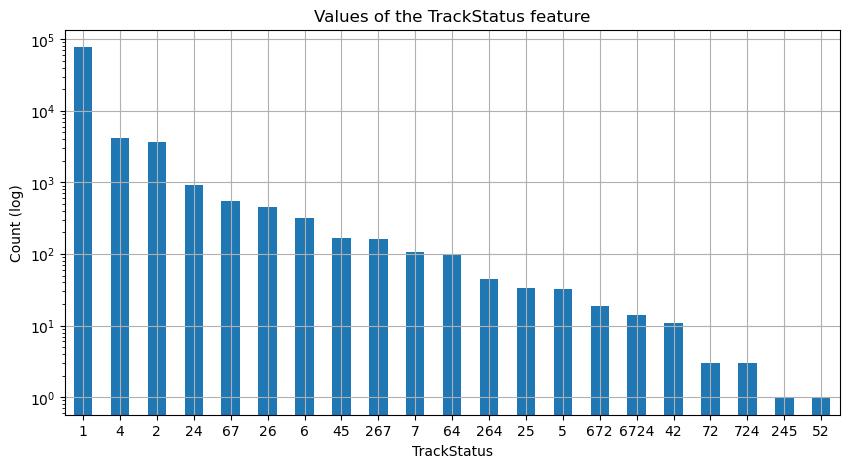

In [193]:
df['TrackStatus'].value_counts().plot(kind='bar', title='Values of the TrackStatus feature', figsize=(10, 5), logy=True, ylabel='Count (log)', xlabel='TrackStatus', grid=True, rot=0)

Pour utiliser cette feature je vais la transformer en 6 features binaires. Chaque feature représente un statut de la piste. Si le statut est présent dans la colonne TrackStatus alors la feature vaut 1 sinon elle vaut 0.

<AxesSubplot: title={'center': 'Values of the TrackStatus feature'}, xlabel='TrackStatus', ylabel='Count (log)'>

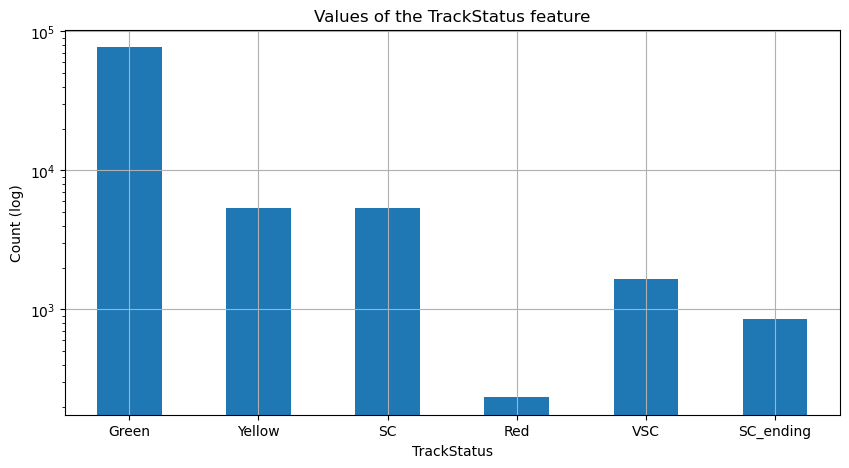

In [194]:
def trackStatus_to_binary(trackStatus):
    status = pd.Series(
        np.zeros(6, dtype=np.bool8),
        index=['Green', 'Yellow', 'SC', 'Red', 'VSC', 'SC_ending']
    )
    if "1" in trackStatus:
        status['Green'] = True
    if "2" in trackStatus:
        status['Yellow'] = True
    if "4" in trackStatus:
        status['SC'] = True
    if "5" in trackStatus:
        status['Red'] = True
    if "6" in trackStatus:
        status['VSC'] = True
    if "7" in trackStatus:
        status['SC_ending'] = True
    return status

trackStatuses = df['TrackStatus'].apply(trackStatus_to_binary)
df = pd.concat([df.drop('TrackStatus', axis=1), trackStatuses], axis=1).reset_index(drop=True)
df[['Green', 'Yellow', 'SC', 'Red', 'VSC', 'SC_ending']].sum().plot(kind='bar', title='Values of the TrackStatus feature', figsize=(10, 5), logy=True, ylabel='Count (log)', xlabel='TrackStatus', grid=True, rot=0)

### Valeurs manquantes
* On remarque que il y a **20** tours ou il n'y a pas de données météo, étant donnée que dans un premier temps on ne va pas utiliser les données météo, on peut les garder.
* Plus problématique, il y a **6'455** tours sans données `DriverAhead` et `DistanceToDriverAhead`. Je suspecte que ça soit les tours de sortie de débuts de course et simplement les tours du pilote leader de la course.
* Il y a également **3'261** tours sans données `LapTime`, je suspecte que ça soit aussi les tours de sortie de débuts de course.

In [195]:
df_cleaning = df[df['DriverAhead'].isna()]
df_cleaning.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6421 entries, 0 to 87829
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   LapStartTime             6421 non-null   float32 
 1   LapNumber                6421 non-null   uint8   
 2   LapTime                  4546 non-null   float32 
 3   DriverNumber             6421 non-null   object  
 4   Team                     6421 non-null   object  
 5   Compound                 6421 non-null   object  
 6   TyreLife                 6421 non-null   uint8   
 7   Stint                    6421 non-null   uint8   
 8   DistanceToDriverAhead    0 non-null      float32 
 9   DriverAhead              0 non-null      object  
 10  PitStatus                6421 non-null   category
 11  IsAccurate               6421 non-null   bool    
 12  NumberOfPitStops         6421 non-null   uint8   
 13  Position                 6421 non-null   uint8   
 14  GapToLe

Premièrement, je remarque qu'il y a uniquement **1'909** lignes avec des valeurs manquantes pour `LapTime`, se qui veut dire que **1'352** autres tours n'ont pas de laptime.

<AxesSubplot: title={'center': 'Histogram of Lap n° without a driver ahead'}, xlabel='LapNumber', ylabel='Count'>

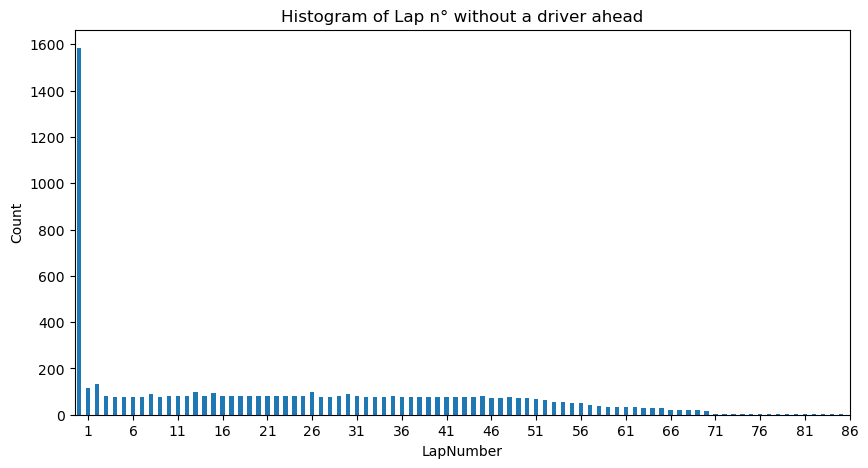

In [196]:
pd.Series(df_cleaning['LapNumber']).value_counts().sort_index().plot(
    kind='bar', 
    figsize=(10, 5), 
    title='Histogram of Lap n° without a driver ahead', 
    xlabel='LapNumber', 
    ylabel='Count',
    xticks=np.arange(
        start=df_cleaning['LapNumber'].min(), 
        stop=df_cleaning['LapNumber'].max(),
        step=5
    ),
    rot=0,
)


Comme attendu, la plupart des lignes avec des valeurs manquantes sont des lignes de début de course avant le 2ème tour. Le reste de la distribution est assez uniforme avec une légère diminution de la fréquence après 55 tours, ce qui est logique car la majorité des courses durent entre 50 et 60 tours.

Je vais donc supprimer les lignes de début de course, c'est à dire les lignes avec `LapNumber` < 2.

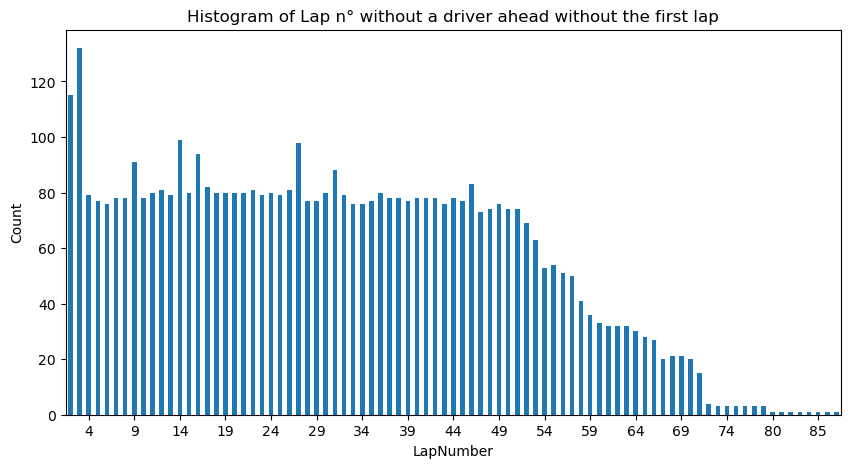

In [197]:
df_cleaning = df_cleaning[df_cleaning['LapNumber'] > 1]

ax = pd.Series(df_cleaning['LapNumber']).value_counts().sort_index().plot(
    kind='bar', 
    figsize=(10, 5), 
    title='Histogram of Lap n° without a driver ahead without the first lap', 
    xlabel='LapNumber', 
    ylabel='Count',
    rot=0,
)

ax.set_xticks(np.arange(
        start=df_cleaning['LapNumber'].min(),
        stop=df_cleaning['LapNumber'].max(),
        step=5
    )
)


In [198]:
df = df[df['LapNumber'] > 1]

---

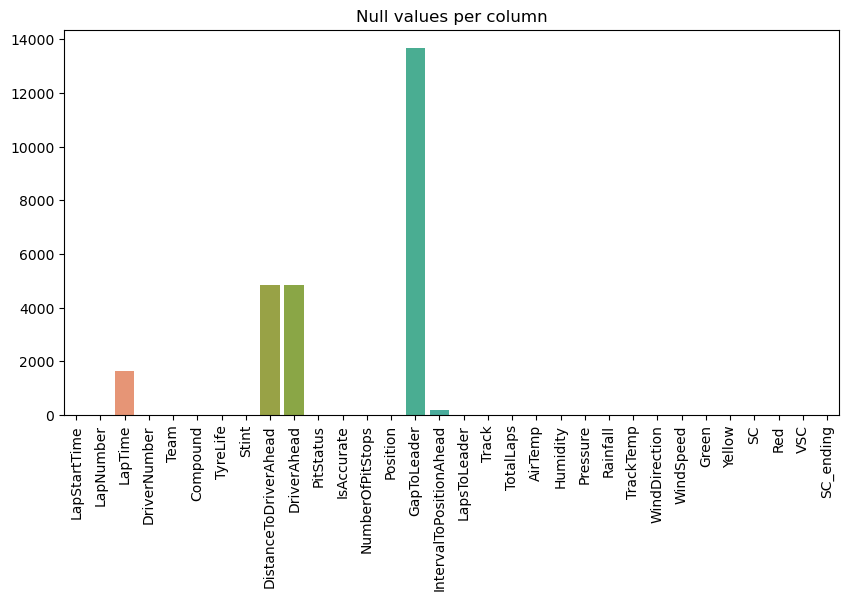

In [199]:
# Bar chart of the null values per column using seaborn
plt.figure(figsize=(10, 5))
sns.barplot(x=df.isna().sum().index, y=df.isna().sum().values)
plt.title('Null values per column')
plt.xticks(rotation=90)
plt.show()


On remarque que maintenant que quasiment toutes les lignes avec des valeurs manquantes pour `LapTime` ont été supprimées. 

Les tours sans données `DriverAhead` et `DistanceToDriverAhead` sont maintenant uniquement les tours du pilote leader de la course se qui est logique.

Les valeurs null de `GapToLeader` sont celle des pilotes qui ont au moins un tour de retard sur le leader de la course. Similairement, les valeurs manquantes de `IntervalToPositionAhead` sont celles des pilotes qui ont au moins un tour de retard sur la voiture devant eux (se qui est rare et explique le nombre plus faible d'occurence)

*Il semble qu'au passage, on ait supprimé les lignes avec les valeurs de météo manquantes*

Il reste cependant, **1645** tours sans données pour la colonne 'LapTime`.

In [212]:
df['HasLapTime'] = ~df['LapTime'].isna()

<AxesSubplot: title={'center': 'LapTime null values per TrackStatus'}, xlabel='HasLapTime', ylabel='Count'>

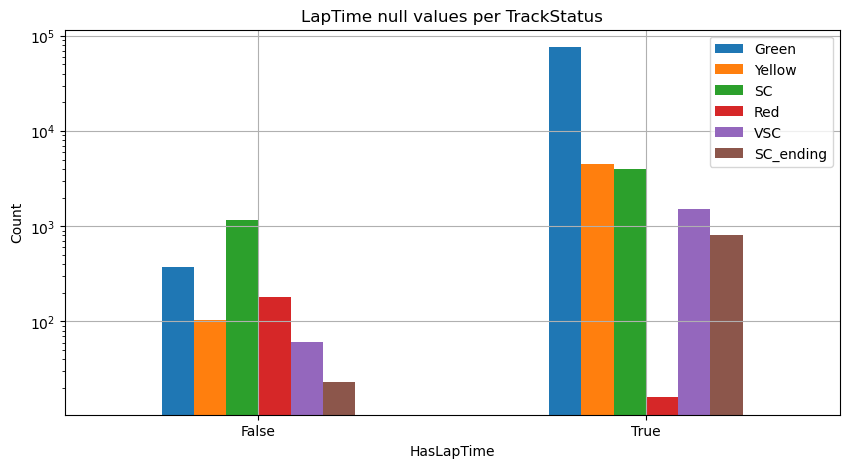

In [206]:
df[['HasLapTime', 'Green', 'Yellow', 'SC', 'Red', 'VSC', 'SC_ending']].groupby('HasLapTime').sum().plot(kind='bar', figsize=(10, 5), title='LapTime null values per TrackStatus', xlabel='HasLapTime', ylabel='Count', rot=0, grid=True, logy=True)

C:\Users\NelsonWork\AppData\Local\Temp\ipykernel_14536\3827230562.py:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corrwith(df['HasLapTime']).plot(kind='bar', figsize=(20, 5), title='Correlation with HasLapTime', xlabel='Feature', ylabel='Correlation', grid=True)


<AxesSubplot: title={'center': 'Correlation with HasLapTime'}, xlabel='Feature', ylabel='Correlation'>

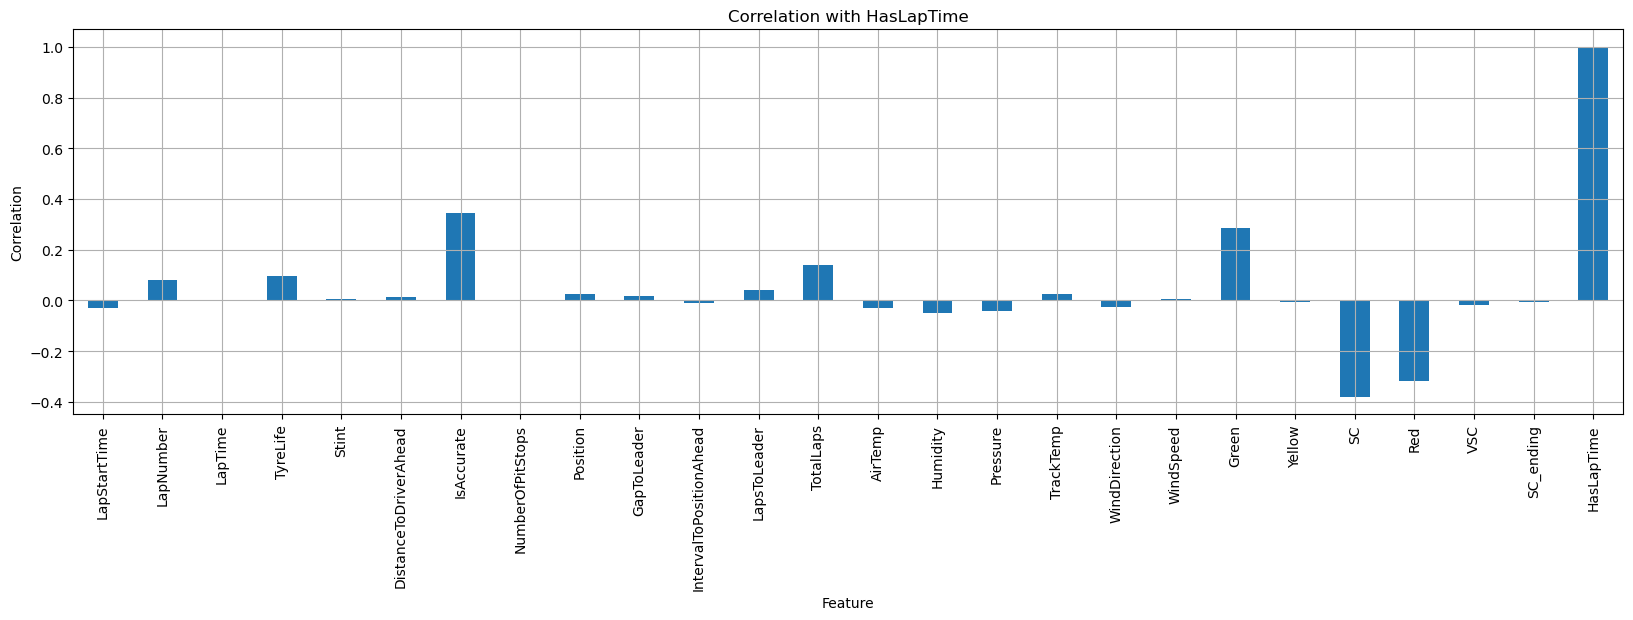

In [207]:
df.corrwith(df['HasLapTime']).plot(kind='bar', figsize=(20, 5), title='Correlation with HasLapTime', xlabel='Feature', ylabel='Correlation', grid=True)

---
Il semble difficile de définir une règle pour remplir les valeurs manquantes. Je vais donc simplement supprimer les lignes avec des valeurs manquantes.

In [213]:
df = df.drop(axis=0, index=df[df['HasLapTime'] == False].index)
df = df.drop('HasLapTime', axis=1)

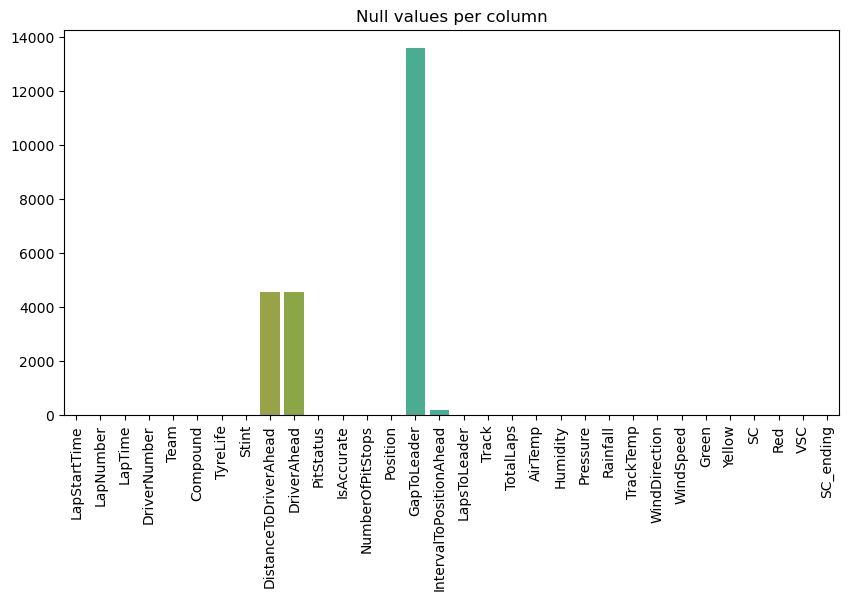

In [214]:
# Bar chart of the null values per column using seaborn
plt.figure(figsize=(10, 5))
sns.barplot(x=df.isna().sum().index, y=df.isna().sum().values)
plt.title('Null values per column')
plt.xticks(rotation=90)
plt.show()

In [187]:
# boolean
df['Green'] = df['Green'].astype('bool')
df['Yellow'] = df['Yellow'].astype('bool')
df['SC'] = df['SC'].astype('bool')
df['Red'] = df['Red'].astype('bool')
df['VSC'] = df['VSC'].astype('bool')
df['SC_ending'] = df['SC_ending'].astype('bool')
df['IsAccurate'] = df['IsAccurate'].astype('bool')
df['Rainfall'] = df['Rainfall'].astype('bool')
# category
df['DriverNumber'] = df['DriverNumber'].astype('category')
df['Team'] = df['Team'].astype('category')
df['Compound'] = df['Compound'].astype('category')
df['DriverAhead'] = df['DriverAhead'].astype('category')
df['Track'] = df['Track'].astype('category')
# float
df['LapStartTime'] = df['LapStartTime'].astype('float32')
df['LapTime'] = df['LapTime'].astype('float32')
df['DistanceToDriverAhead'] = df['DistanceToDriverAhead'].astype('float32')
df['GapToLeader'] = df['GapToLeader'].astype('float32')
df['IntervalToPositionAhead'] = df['IntervalToPositionAhead'].astype('float32')
df['AirTemp'] = df['AirTemp'].astype('float32')
df['Humidity'] = df['Humidity'].astype('float32')
df['Pressure'] = df['Pressure'].astype('float32')
df['TrackTemp'] = df['TrackTemp'].astype('float32')
df['WindDirection'] = df['WindDirection'].astype('float32')
df['WindSpeed'] = df['WindSpeed'].astype('float32')
# int
df['LapNumber'] = df['LapNumber'].astype('uint8')
df['TyreLife'] = df['TyreLife'].astype('uint8')
df['Stint'] = df['Stint'].astype('uint8')
df['NumberOfPitStops'] = df['NumberOfPitStops'].astype('uint8')
df['Position'] = df['Position'].astype('uint8')
df['LapsToLeader'] = df['LapsToLeader'].astype('uint8')
df['TotalLaps'] = df['TotalLaps'].astype('uint8')

#### Ajout de la colonne target is_pitting

La problématique de prédiction d'un arrêt au stand est un problème de classification binaire (is_pitting ou pas), il faut transformer l'information de la colonne PitStatus pour obtenir les 2 classes.

In [18]:
df['is_pitting'] = df['PitStatus'] == 'InLap'

#### Suppression des colonnes inutiles

Dans un premier temps, je ne vais pas considérer certaines variables notamment :
* Les données météos
* L'identité des pilotes (dans un second temps, je pense poursuivre la piste d'une feature teammate pour savoir la position du coéquipier)

In [19]:
df.drop(['LapStartTime', 'DriverNumber', 'Team', 'DriverAhead', 'AirTemp', 'Humidity', 'Pressure',
'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed'], axis=1, inplace=True)

### TODO - Ajouter un ID à la course pour supprimer les courses qui utilisent les intermédiaires et les wets

<AxesSubplot: title={'center': 'Number of laps per compound'}, xlabel='Compound', ylabel='Count'>

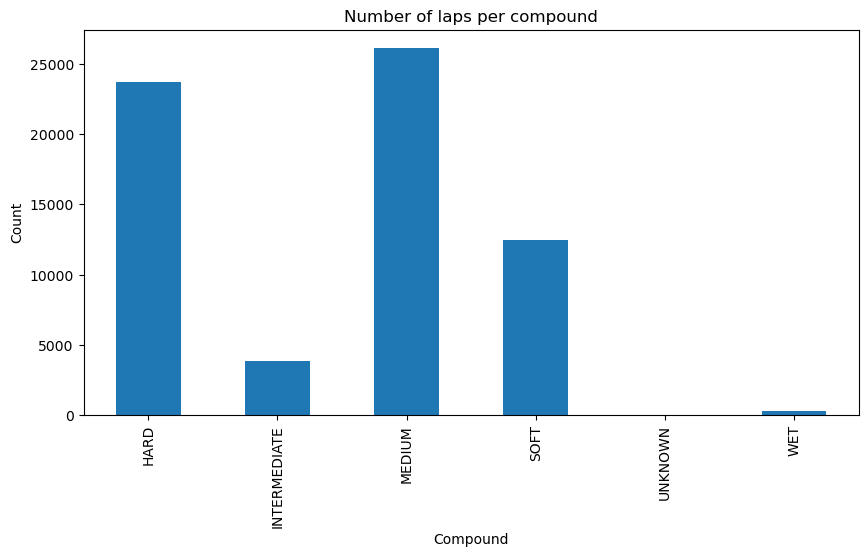

In [20]:
df.groupby('Compound').size().plot(
    kind='bar', 
    figsize=(10, 5),
    title='Number of laps per compound',
    xlabel='Compound',
    ylabel='Count',
    )

### Analyse de forme

* Variable target : is_pitting
* Lignes et colonnes : 66'488 lignes, 22 colonnes
* Types de variables :
  * quantitative : 11
  * qualitative : 11
* Valeurs manquantes : Très peu, environ 1600 lignes soit ~2% du dataset => suprimées

In [21]:
df.shape

(66488, 22)

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66488 entries, 21 to 87844
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   LapNumber                66488 non-null  float64 
 1   LapTime                  66488 non-null  float32 
 2   Compound                 66488 non-null  category
 3   TyreLife                 66488 non-null  float64 
 4   Stint                    66488 non-null  float64 
 5   DistanceToDriverAhead    66488 non-null  float32 
 6   PitStatus                66488 non-null  category
 7   IsAccurate               66488 non-null  object  
 8   NumberOfPitStops         66488 non-null  float64 
 9   Position                 66488 non-null  float64 
 10  GapToLeader              66488 non-null  float32 
 11  IntervalToPositionAhead  66488 non-null  float32 
 12  LapsToLeader             66488 non-null  float64 
 13  Track                    66488 non-null  category
 14  Total

<AxesSubplot: title={'center': 'Data types distribution'}>

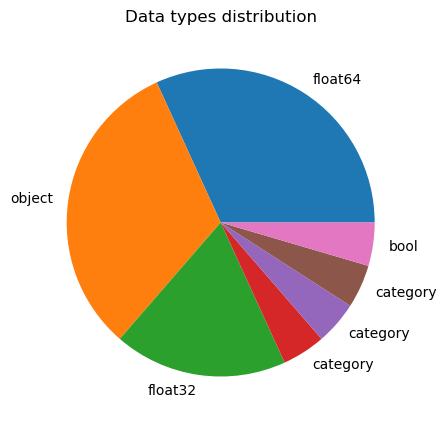

In [23]:
df.dtypes.value_counts().plot.pie(
    figsize=(5, 5),
    title='Data types distribution',
)

### Analyse de Fond

* Visualisation de la target : Très déséquilibré (3% de cas positifs)
* Signification des variables :
* Relation Variables / Target :

In [24]:
df['is_pitting'].value_counts(normalize=True)

False    0.969348
True     0.030652
Name: is_pitting, dtype: float64

#### Variables quantitatives

In [25]:
df2 = df.copy()

In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

columns_to_scale = df2.select_dtypes(include='number').columns

df2[columns_to_scale] = scaler.fit_transform(df2[columns_to_scale])

df2.head()

,LapNumber,LapTime,Compound,TyreLife,Stint,DistanceToDriverAhead,PitStatus,IsAccurate,NumberOfPitStops,Position,...,LapsToLeader,Track,TotalLaps,Green,Yellow,SC,Red,VSC,SC_ending,is_pitting
21,-1.49322,-0.147158,SOFT,-0.998619,-1.009523,-0.126840,NoPit,True,-0.987065,-1.473923,...,0.0,Melbourne,-0.348619,True,False,False,False,False,False,False
22,-1.49322,-0.124505,SOFT,-0.998619,-1.009523,-0.172226,NoPit,True,-0.987065,-1.271983,...,0.0,Melbourne,-0.348619,True,False,False,False,False,False,False
23,-1.49322,-0.127337,SOFT,-0.998619,-1.009523,-0.158210,NoPit,True,-0.987065,-1.070043,...,0.0,Melbourne,-0.348619,True,False,False,False,False,False,False
24,-1.49322,-0.088031,SOFT,-0.998619,-1.009523,-0.155478,NoPit,True,-0.987065,-0.868103,...,0.0,Melbourne,-0.348619,True,False,False,False,False,False,False
25,-1.49322,-0.069424,SOFT,-0.998619,-1.009523,-0.137029,NoPit,True,-0.987065,-0.666163,...,0.0,Melbourne,-0.348619,True,False,False,False,False,False,False


##### LapNumber

La variable ``LapNumber`` représente le numéro du tour. On remarque que la distribution est très uniforme, ce qui est logique car la majorité des courses durent entre 50 et 60 tours. On remarque par contre qu'elle est asymétrique, ce qui est logique car certaines voitures ne terminent pas la course.

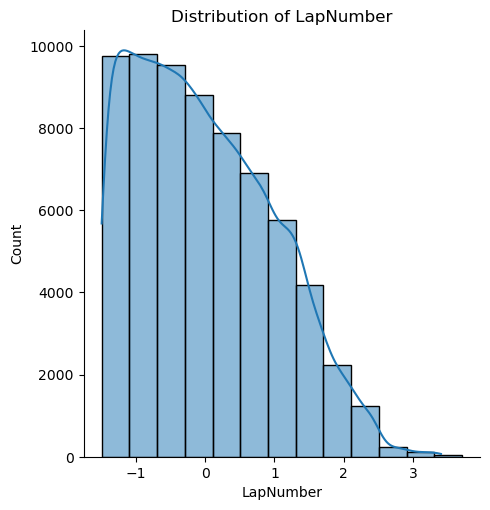

In [137]:
sns.displot(df2['LapNumber'], kde=True, binwidth=0.4)
plt.title('Distribution of LapNumber')
plt.show()

##### LapTime

La variable ``LapTime`` représente le temps du tour en secondes. On remarque que la distribution est assez uniforme et symétrique.

In [110]:
df2['LapTime'].max()-df2['LapTime'].min()

6.373641570504841

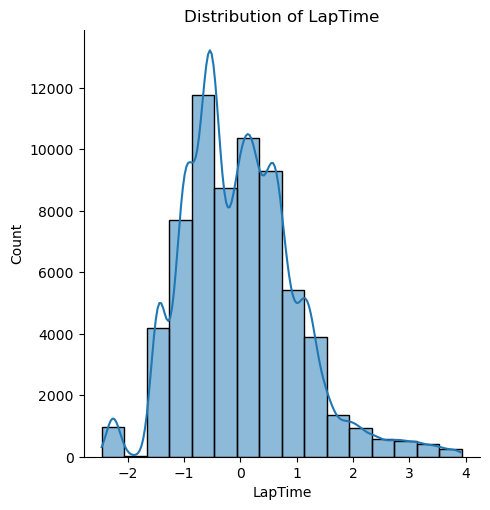

In [117]:
sns.displot(df2['LapTime'], kde=True, binwidth=0.4)
plt.title('Distribution of LapTime')
plt.show()

##### TyreLife

La distribution est uniforme mais asymetrique, cela est dû à la nature de l'évolution de l'age des pneumatiques lors de la course. Sur une course de 60 tours, une voiture qui s'arrête tout les 20 tours aura 3 tours avec `TyreLife=[1..20]`. Comparé à une voiture qui fait aucun arrêt.

In [108]:
df2['TyreLife'].max()-df2['TyreLife'].min()

6.769167788556755

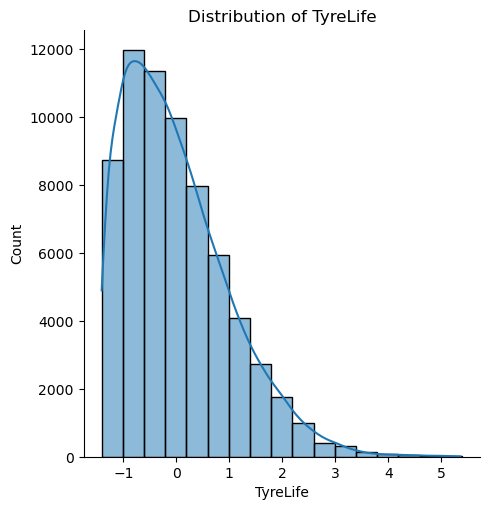

In [139]:
sns.displot(df2['TyreLife'], kde=True, binwidth=0.4)
plt.title('Distribution of TyreLife')
plt.show()

##### Stint

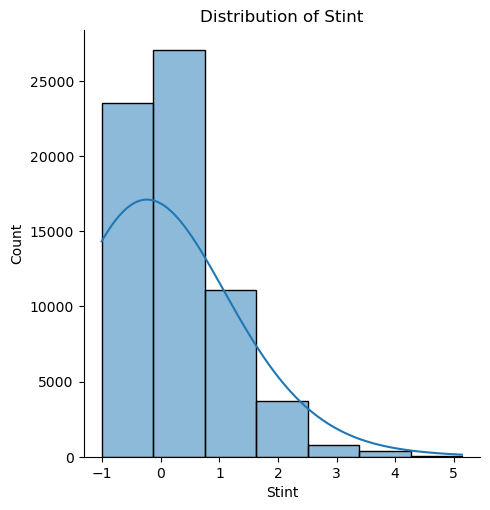

In [98]:
sns.displot(df2['Stint'], kde=True, bins=7, kde_kws={'bw_method':1})
plt.title('Distribution of Stint')
plt.show()

##### NumberOfPitStops

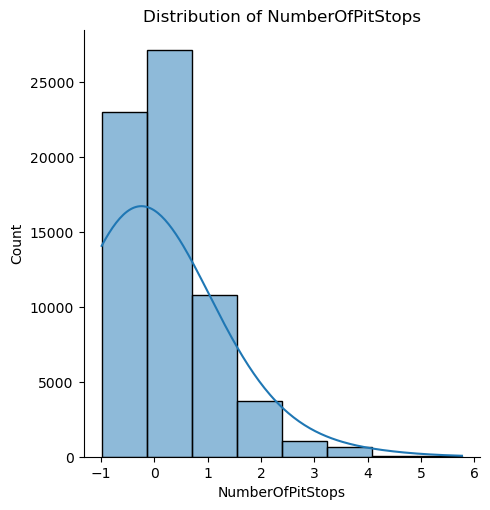

In [126]:
sns.displot(df2['NumberOfPitStops'], kde=True, bins=8, kde_kws={'bw_method':1})
plt.title('Distribution of NumberOfPitStops')
plt.show()

##### Position

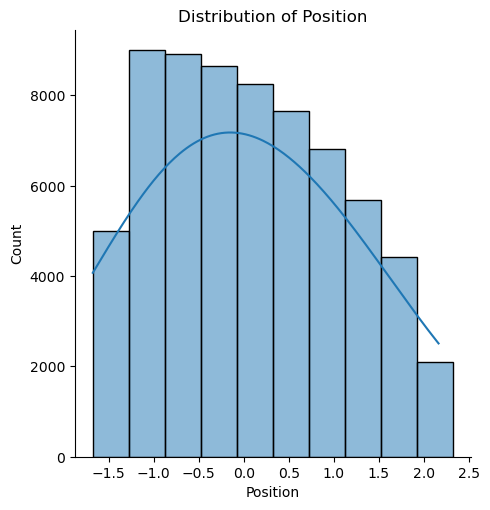

In [132]:
sns.displot(df2['Position'], kde=True, binwidth=0.4, kde_kws={'bw_method':1})
plt.title('Distribution of Position')
plt.show()

##### GapToLeader

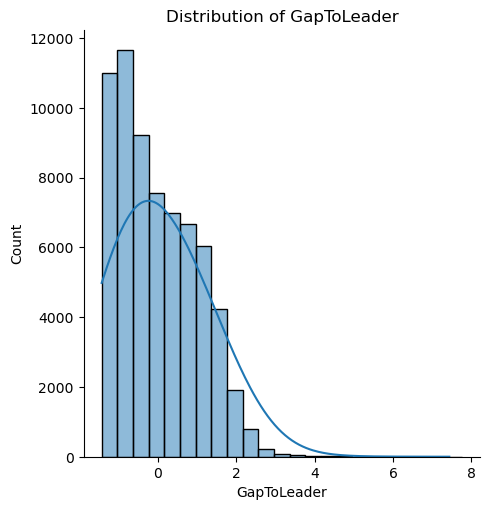

In [134]:
sns.displot(df2['GapToLeader'], kde=True, binwidth=0.4, kde_kws={'bw_method':1})
plt.title('Distribution of GapToLeader')
plt.show()

##### DistanceToDriverAhead

La distribution est très "piquée" avec énormément de valeurs entre 0 et 1 et le reste dispercée entre 10 et 100

p:\Anaconda\envs\bsc\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


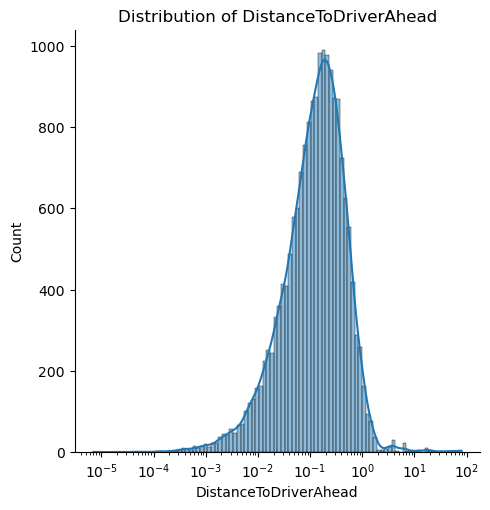

In [143]:
sns.displot(df2['DistanceToDriverAhead'], kde=True, bins=100, log_scale=True)
plt.title('Distribution of DistanceToDriverAhead')
plt.show()

##### IntervalToPositionAhead

p:\Anaconda\envs\bsc\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


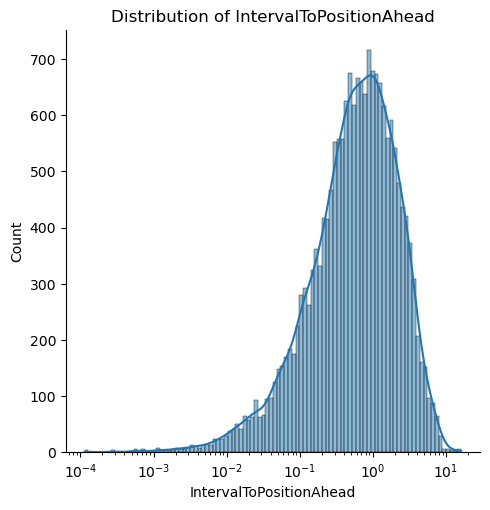

In [146]:
sns.displot(df2['IntervalToPositionAhead'], kde=True, bins=100, log_scale=True)
plt.title('Distribution of IntervalToPositionAhead')
plt.show()

##### LapsToLeader

In [151]:
df2['LapsToLeader'].describe()

count    66488.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: LapsToLeader, dtype: float64

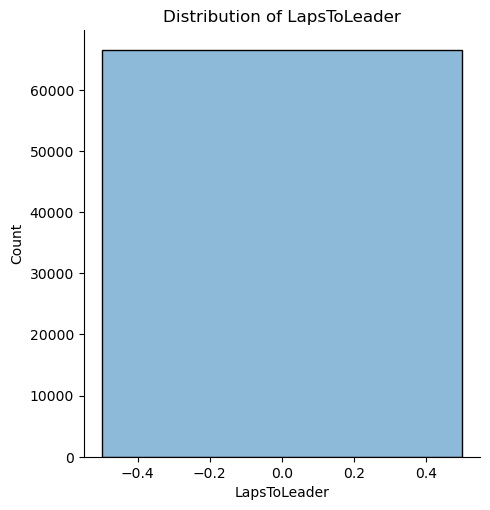

In [149]:
sns.displot(df2['LapsToLeader'], kde=True)
plt.title('Distribution of LapsToLeader')
plt.show()

##### TotalLaps

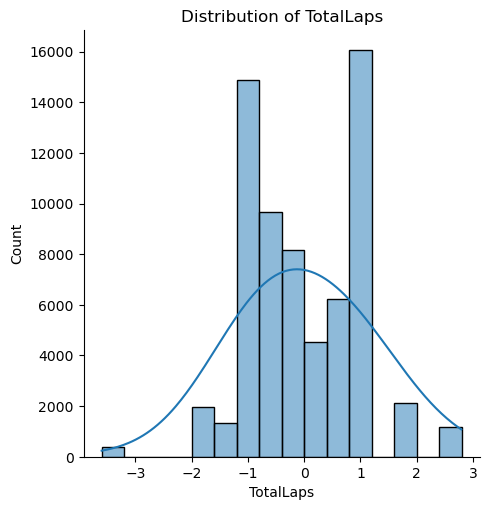

In [154]:
sns.displot(df2['TotalLaps'], kde=True, binwidth=0.4, kde_kws={'bw_method':1})
plt.title('Distribution of TotalLaps')
plt.show()

#### Variables qualitatives

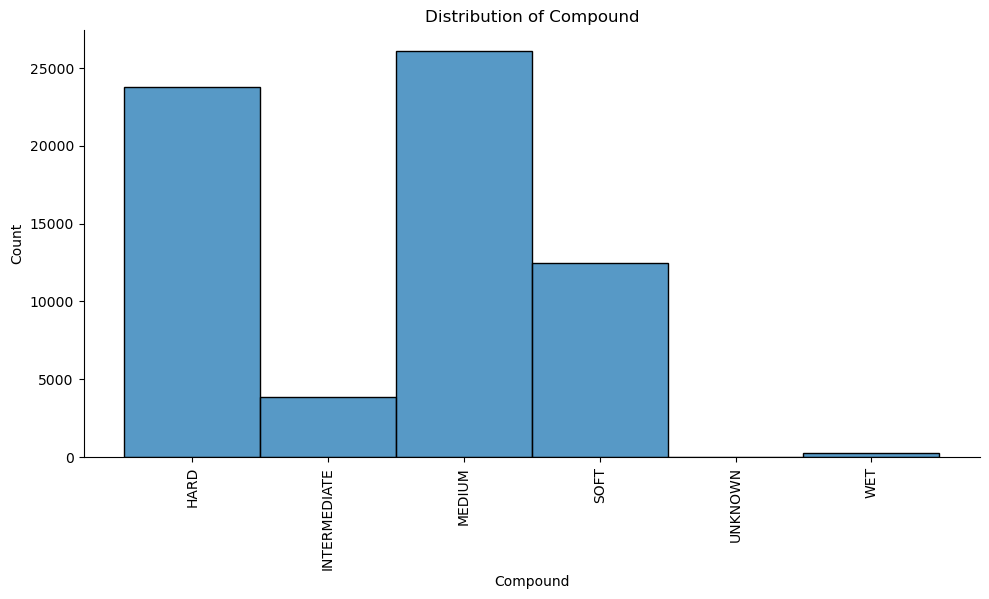

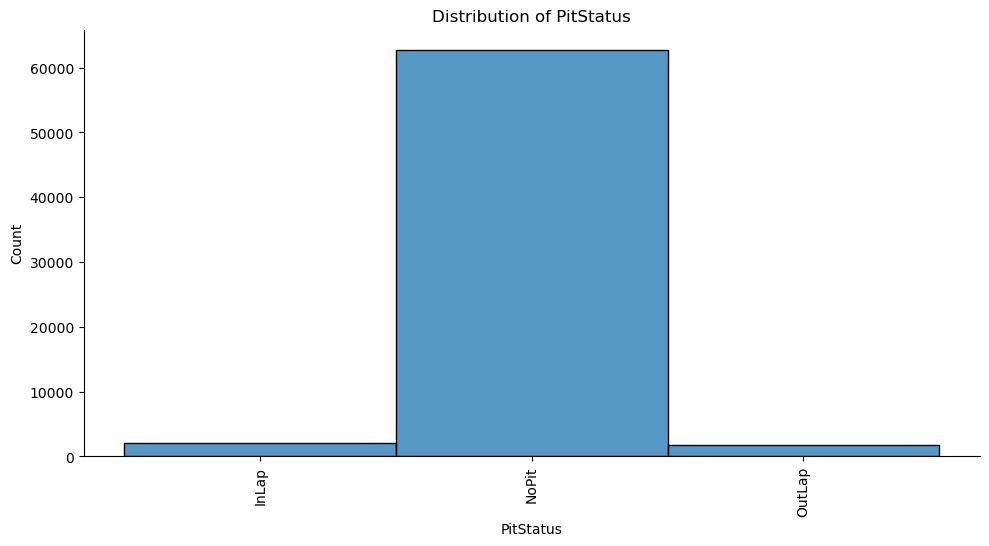

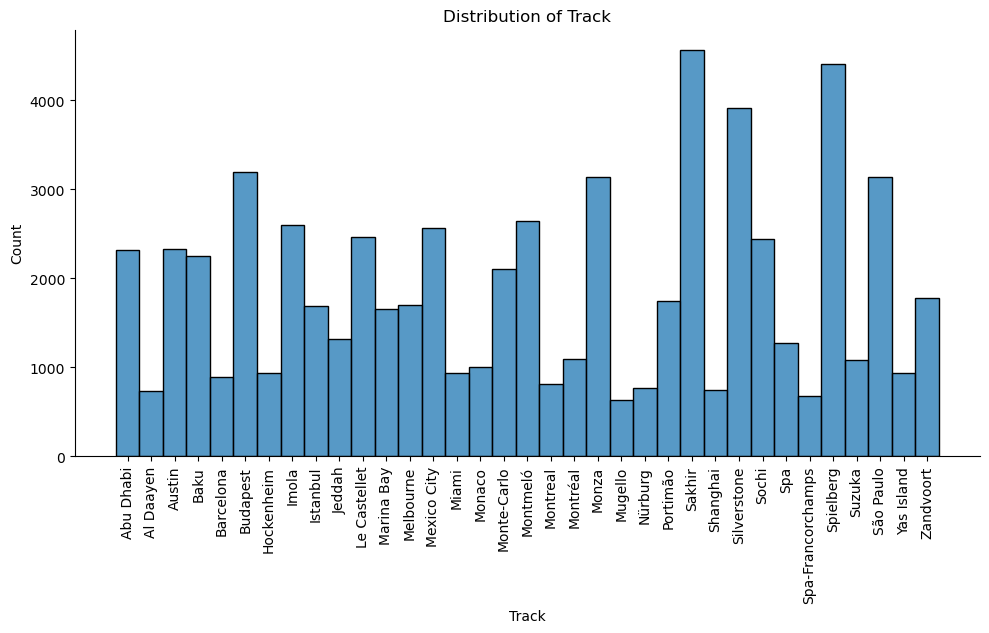

In [28]:
for col in df.select_dtypes(include='category').columns:
    sns.displot(df[col], height=5, aspect=2)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=90)
    plt.show()